# Imports

In [1]:
using DataFrames
using CSV
using MLJ
using Flux
using Plots
using StatsBase
using MLJ: confusion_matrix

include("../../lib.jl")

ENV["LINES"]=30;

In [2]:
mkdir("./Figures")

LoadError: IOError: mkdir: file already exists (EEXIST)

# Datasets

In [3]:
data = CSV.read("data.csv")

,Mean of the integrated profile,Standard deviation of the integrated profile
,Float64,Float64
1,140.562,55.6838
2,102.508,58.8824
3,103.016,39.3416
4,136.75,57.1784
5,88.7266,40.6722
6,93.5703,46.6981
7,119.484,48.7651
8,130.383,39.8441
9,107.25,52.6271


In [4]:
describe(data)

,variable,mean,min,median,max
,Symbol,Float64,Real,Float64,Real
1,Mean of the integrated profile,111.08,5.8125,115.078,192.617
2,Standard deviation of the integrated profile,46.5495,24.772,46.9475,98.7789
3,Excess kurtosis of the integrated profile,0.477857,-1.87601,0.22324,8.06952
4,Skewness of the integrated profile,1.77028,-1.79189,0.19871,68.1016
5,Mean of the DM-SNR curve,12.6144,0.213211,2.80184,223.392
6,Standard deviation of the DM-SNR curve,26.3265,7.37043,18.4613,110.642
7,Excess kurtosis of the DM-SNR curve,8.30356,-3.13927,8.43351,34.5398
8,Skewness of the DM-SNR curve,104.858,-1.97698,83.0646,1191.0
9,target_class,0.0915745,0,0.0,1


Look at class labels to see if dataset is imbalanced

In [5]:
label_counts = countmap(data[:target_class])

Dict{Int64,Int64} with 2 entries:
  0 => 16259
  1 => 1639

In [6]:
collect(label_counts[i] / size(data)[1] for i in keys(label_counts))

2-element Array{Float64,1}:
 0.908425522404738
 0.09157447759526204

Get data ready for training

In [7]:
coerce!(data, :target_class=>Multiclass)
schema(data)

┌───────────────────────────────────────────────┬────────────────────────────────┬───────────────┐
│ _.names                                       │ _.types                        │ _.scitypes    │
├───────────────────────────────────────────────┼────────────────────────────────┼───────────────┤
│  Mean of the integrated profile               │ Float64                        │ Continuous    │
│  Standard deviation of the integrated profile │ Float64                        │ Continuous    │
│  Excess kurtosis of the integrated profile    │ Float64                        │ Continuous    │
│  Skewness of the integrated profile           │ Float64                        │ Continuous    │
│  Mean of the DM-SNR curve                     │ Float64                        │ Continuous    │
│  Standard deviation of the DM-SNR curve       │ Float64                        │ Continuous    │
│  Excess kurtosis of the DM-SNR curve          │ Float64                        │ Continuous    │
│  Skewnes

In [8]:
y, X = unpack(data, ==(:target_class), colname->true)

(CategoricalValue{Int64,UInt32}[0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 17898×8 DataFrame. Omitted printing of 7 columns
│ Row   │  Mean of the integrated profile │
│       │ Float64                         │
├───────┼─────────────────────────────────┤
│ 1     │ 140.562                         │
│ 2     │ 102.508                         │
│ 3     │ 103.016                         │
│ 4     │ 136.75                          │
│ 5     │ 88.7266                         │
│ 6     │ 93.5703                         │
│ 7     │ 119.484                         │
│ 8     │ 130.383                         │
│ 9     │ 107.25                          │
│ 10    │ 107.258                         │
⋮
│ 17888 │ 121.375                         │
│ 17889 │ 98.7266                         │
│ 17890 │ 126.625                         │
│ 17891 │ 143.672                         │
│ 17892 │ 118.484                         │
│ 17893 │ 96.0                            │
│ 17894 │ 136.43 

Partition train and test data accoring to class labels

In [202]:
# data to use when trying to fit a single validation set
train, test = partition(eachindex(y), 0.7, shuffle=true, rng=545, stratify=values(data[:target_class])) # gives 70:30 split

([9636, 6944, 9876, 2005, 5202, 4057, 766, 11725, 907, 4373  …  14095, 5189, 17121, 8818, 130, 11824, 5835, 5122, 5073, 4378], [8648, 13422, 12124, 2436, 9809, 11446, 9765, 14476, 13541, 3591  …  15314, 13601, 5644, 2386, 9062, 10452, 15638, 17255, 1140, 7129])

In [203]:
train_counts = countmap(data[train,:target_class])
collect(train_counts[i] / size(train)[1] for i in keys(train_counts))

2-element Array{Float64,1}:
 0.9084450830140486
 0.09155491698595147

In [204]:
test_counts = countmap(data[test,:target_class])
collect(test_counts[i] / size(test)[1] for i in keys(test_counts))

2-element Array{Float64,1}:
 0.9083798882681564
 0.09162011173184358

# Five Learning Algorithms

* Decision trees with some form of pruning
* Neural networks
* Boosting
* Support Vector Machines
* k-nearest neighbors


##### Testing
* Implement the algorithms
* Design two *interesting* classification problems. For the purposes of this assignment, a classification problem is just a set of training examples and a set of test examples.

In [205]:
models(matching(X,y))

43-element Array{NamedTuple{(:name, :package_name, :is_supervised, :docstring, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :is_pure_julia, :is_wrapper, :load_path, :package_license, :package_url, :package_uuid, :prediction_type, :supports_online, :supports_weights, :input_scitype, :target_scitype, :output_scitype),T} where T<:Tuple,1}:
 (name = AdaBoostClassifier, package_name = ScikitLearn, ... )
 (name = AdaBoostStumpClassifier, package_name = DecisionTree, ... )
 (name = BaggingClassifier, package_name = ScikitLearn, ... )
 (name = BayesianLDA, package_name = MultivariateStats, ... )
 (name = BayesianLDA, package_name = ScikitLearn, ... )
 (name = BayesianQDA, package_name = ScikitLearn, ... )
 (name = BayesianSubspaceLDA, package_name = MultivariateStats, ... )
 (name = ConstantClassifier, package_name = MLJModels, ... )
 (name = DecisionTreeClassifier, package_name = DecisionTree, ... )
 (name = DeterministicConstantClassifier, package_na

In [206]:
@load NeuralNetworkClassifier verbosity=2

┌ Info: Model code for NeuralNetworkClassifier already loaded
└ @ MLJModels /home/andrew/.julia/packages/MLJModels/mUBFt/src/loading.jl:54


NeuralNetworkClassifier(
    builder = Short(
            n_hidden = 0,
            dropout = 0.5,
            σ = NNlib.σ),
    finaliser = NNlib.softmax,
    optimiser = ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}()),
    loss = Flux.crossentropy,
    epochs = 10,
    batch_size = 1,
    lambda = 0.0,
    alpha = 0.0,
    optimiser_changes_trigger_retraining = false) @622

## Neural networks
* Use favorite kind of network and training algorithm. 
* You may use networks of nodes with as many layers as you like and any activation function you see fit.

1. https://github.com/alan-turing-institute/MLJFlux.jl/blob/master/examples/boston.ipynb
1. https://github.com/alan-turing-institute/MLJFlux.jl
1. https://alan-turing-institute.github.io/MLJ.jl/dev/transformers/

In [207]:
# Define a custom network
mutable struct CustomNN <:MLJFlux.Builder
    n1 ::Int
    n2 ::Int
end

In [208]:
function MLJFlux.build(nn::CustomNN, n_in, n_out)
    return Chain(
        Flux.Dense(n_in, nn.n1, σ),
        Flux.Dense(nn.n1, nn.n2, σ),
        Flux.Dense(nn.n2, n_out, σ),
    )
end

In [209]:
layer1 = 80
layer2 = 40

40

In [210]:
batch_sz = 16;

In [211]:
max_epochs = 2000;

### No-preprocessing

In [212]:
nn = NeuralNetworkClassifier(builder=CustomNN(layer1,layer2))

NeuralNetworkClassifier(
    builder = CustomNN(
            n1 = 80,
            n2 = 40),
    finaliser = NNlib.softmax,
    optimiser = ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}()),
    loss = Flux.crossentropy,
    epochs = 10,
    batch_size = 1,
    lambda = 0.0,
    alpha = 0.0,
    optimiser_changes_trigger_retraining = false) @680

In [213]:
Net = machine(nn, X, y)

Machine{NeuralNetworkClassifier{CustomNN,…}} @704 trained 0 times.
  args: 
    1:	Source @640 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @883 ⏎ `AbstractArray{Multiclass{2},1}`


In [214]:
nn.optimiser.eta = 0.001
nn.epochs = 60
nn.batch_size = batch_sz
nn.lambda = 0.01

0.01

In [215]:
fit!(Net, rows=train, verbosity=2)

┌ Info: Training Machine{NeuralNetworkClassifier{CustomNN,…}} @704.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
┌ Info: Loss is 0.3403
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.3385
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.338
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.3376
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.3373
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.3374
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.3371
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.3372
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.3372
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.337

Machine{NeuralNetworkClassifier{CustomNN,…}} @704 trained 1 time.
  args: 
    1:	Source @640 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @883 ⏎ `AbstractArray{Multiclass{2},1}`


In [216]:
nn.optimiser.eta = nn.optimiser.eta / 3
nn.epochs = nn.epochs + 40

100

In [217]:
fit!(Net, rows=train, verbosity=2)

┌ Info: Updating Machine{NeuralNetworkClassifier{CustomNN,…}} @704.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:320
┌ Info: Loss is 0.3358
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.3356
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.3354
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.3353
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.3353
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.3352
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.3351
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.3351
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.335
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.335

Machine{NeuralNetworkClassifier{CustomNN,…}} @704 trained 2 times.
  args: 
    1:	Source @640 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @883 ⏎ `AbstractArray{Multiclass{2},1}`


In [218]:
nn_acc = evaluate!(Net, resampling=CV(shuffle=true), measure=[cross_entropy, acc], verbosity=1)

Evaluating over 6 folds: 100%[=========================] Time: 0:02:11


┌───────────────┬───────────────┬───────────────────────────────────────────────────┐
│ _.measure     │ _.measurement │ _.per_fold                                        │
├───────────────┼───────────────┼───────────────────────────────────────────────────┤
│ cross_entropy │ 0.336         │ Float32[0.335, 0.341, 0.339, 0.335, 0.331, 0.335] │
│ acc           │ 0.977         │ [0.979, 0.97, 0.973, 0.978, 0.983, 0.978]         │
└───────────────┴───────────────┴───────────────────────────────────────────────────┘
_.per_observation = [[[0.313, 0.313, ..., 0.313], [0.313, 0.313, ..., 0.313], [0.313, 0.313, ..., 0.313], [0.313, 0.313, ..., 0.313], [0.313, 0.313, ..., 0.313], [0.313, 0.313, ..., 0.313]], missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


In [219]:
fitted_params(Net)

(chain = Chain(Chain(Dense(8, 80, σ), Dense(80, 40, σ), Dense(40, 2, σ)), softmax),)

In [220]:
report(Net)

(training_losses = Any[0.3525623f0, 0.340936f0, 0.33849326f0, 0.3376107f0, 0.3371739f0, 0.3369193f0, 0.33676177f0, 0.3366447f0, 0.33655208f0, 0.33648553f0  …  0.33379182f0, 0.33378997f0, 0.33374816f0, 0.33370128f0, 0.33365902f0, 0.33361894f0, 0.33357382f0, 0.3335458f0, 0.3335019f0, 0.33345821f0],)

### With Preprocessing

Standardizing Inputs makes a huge difference.
Before, I could only barely break below 0.4 training loss, but by standardizing inputs, I can easily get near 0.3.

In [221]:
standardizer = Standardizer()
stand = machine(standardizer, X[train,:]) #only want to standardize on training distribution
fit!(stand)
X_stand = MLJ.transform(stand, X);

┌ Info: Training Machine{Standardizer} @137.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319


In [222]:
Net = machine(nn, X_stand, y)

Machine{NeuralNetworkClassifier{CustomNN,…}} @817 trained 0 times.
  args: 
    1:	Source @862 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @296 ⏎ `AbstractArray{Multiclass{2},1}`


### Learning Curve

In [223]:
Net.model.epochs = max_epochs
fit!(Net, rows=train, verbosity=1, force=true)

┌ Info: Training Machine{NeuralNetworkClassifier{CustomNN,…}} @817.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
Optimising neural net:100%[=========================] Time: 0:07:01


Machine{NeuralNetworkClassifier{CustomNN,…}} @817 trained 1 time.
  args: 
    1:	Source @862 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @296 ⏎ `AbstractArray{Multiclass{2},1}`


In [224]:
nn_acc = evaluate!(Net, resampling=CV(shuffle=true), measure=[cross_entropy, acc], verbosity=1)

Evaluating over 6 folds: 100%[=========================] Time: 0:51:12


┌───────────────┬───────────────┬──────────────────────────────────────────────────┐
│ _.measure     │ _.measurement │ _.per_fold                                       │
├───────────────┼───────────────┼──────────────────────────────────────────────────┤
│ cross_entropy │ 0.333         │ Float32[0.332, 0.33, 0.336, 0.334, 0.337, 0.331] │
│ acc           │ 0.98          │ [0.982, 0.983, 0.978, 0.979, 0.976, 0.982]       │
└───────────────┴───────────────┴──────────────────────────────────────────────────┘
_.per_observation = [[[0.313, 0.313, ..., 0.313], [0.313, 0.313, ..., 0.313], [0.313, 0.313, ..., 0.313], [0.313, 0.313, ..., 0.313], [0.313, 0.313, ..., 0.313], [0.313, 0.313, ..., 0.313]], missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


In [225]:
vals = collect(0:5:max_epochs)
r = range(nn, :epochs, lower=1, upper=max_epochs, scale=:log10)

MLJBase.NumericRange(Int64, :epochs, ... )

In [226]:
curve = MLJ.learning_curve(Net, 
                        range=r, 
                        resampling=Holdout(fraction_train=0.7), 
#                         resampling=CV(nfolds=4), 
                        measure=cross_entropy, 
                        acceleration=CPUProcesses()
)

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…}} @438.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
┌ Info: Attempting to evaluate 28 models.
└ @ MLJTuning /home/andrew/.julia/packages/MLJTuning/Bbgvk/src/tuned_models.jl:494
Evaluating over 28 metamodels: 100%[=========================] Time: 0:06:33


(parameter_name = "epochs",
 parameter_scale = :log10,
 parameter_values = [1, 2, 3, 4, 5, 6, 8, 11, 14, 18  …  189, 246, 319, 415, 539, 701, 911, 1184, 1539, 2000],
 measurements = [0.3454160690307617, 0.3277941346168518, 0.32513612508773804, 0.324642151594162, 0.32456570863723755, 0.32464542984962463, 0.324905663728714, 0.3251715302467346, 0.32518911361694336, 0.3251159191131592  …  0.3242674767971039, 0.3244127035140991, 0.3245244026184082, 0.32466286420822144, 0.324723482131958, 0.3246852457523346, 0.3251120448112488, 0.3248750865459442, 0.32527869939804077, 0.3253720998764038],)

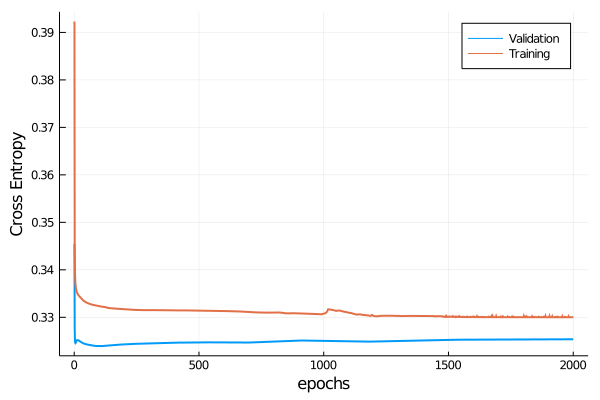

In [227]:
plot(curve.parameter_values,
     curve.measurements,
     xlab=curve.parameter_name,
     ylab="Cross Entropy",
     label="Validation", lw=2)
plot!(Net.report.training_losses, label="Training", lw=2)

In [228]:
a = round(nn.optimiser.eta, digits=5)
b = round(minimum(curve.measurements), digits=5)
best_epochs = curve.parameter_values[argmin(curve.measurements)]
a,b, best_epochs

(0.00033, 0.32394, 112)

In [ ]:
fn = "Figures/LearningCurve_NN_hidden:$(layer1)x$(layer2)_epochs:$(nn.epochs)_lr:$(a)_loss:$(b)_labmda:$(nn.lambda)"
png(replace(fn,'.' => ','))

### GridSearch for Hidden Layer Size 1

In [229]:
Net = machine(nn, X_stand, y)

Machine{NeuralNetworkClassifier{CustomNN,…}} @840 trained 0 times.
  args: 
    1:	Source @546 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @854 ⏎ `AbstractArray{Multiclass{2},1}`


In [230]:
param1 = :epochs
param2 = :(builder.n1)
# param2 = :(builder.n2)

r1 = range(nn, param1, lower=10, upper=100, scale=:log10)
r2 = range(nn, param2, lower=10, upper=100, scale=:linear)

MLJBase.NumericRange(Int64, :(builder.n1), ... )

In [231]:
self_tuning_nn_model = TunedModel(model=nn,
                                    tuning=Grid(goal=64),
                                    resampling=Holdout(fraction_train=0.7), 
                                    measure=cross_entropy,
                                    acceleration=CPUThreads(),
                                    range=[r1, r2])

ProbabilisticTunedModel(
    model = NeuralNetworkClassifier(
            builder = CustomNN @621,
            finaliser = NNlib.softmax,
            optimiser = ADAM(0.0003333333333333333, (0.9, 0.999), IdDict{Any,Any}()),
            loss = Flux.crossentropy,
            epochs = 2000,
            batch_size = 16,
            lambda = 0.01,
            alpha = 0.0,
            optimiser_changes_trigger_retraining = false),
    tuning = Grid(
            goal = 64,
            resolution = 10,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    resampling = Holdout(
            fraction_train = 0.7,
            shuffle = false,
            rng = Random._GLOBAL_RNG()),
    measure = cross_entropy(
            eps = 2.220446049250313e-16),
    weights = nothing,
    operation = MLJModelInterface.predict,
    range = MLJBase.NumericRange{Int64,MLJBase.Bounded,Symbol}[NumericRange{Int64,…} @045, NumericRange{Int64,…} @044],
    train_best = true,
    repeats = 1,
    

In [232]:
self_tuning_nn = machine(self_tuning_nn_model, X_stand, y)

Machine{ProbabilisticTunedModel{Grid,…}} @855 trained 0 times.
  args: 
    1:	Source @434 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @994 ⏎ `AbstractArray{Multiclass{2},1}`


In [233]:
z = fit!(self_tuning_nn, rows=train)

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…}} @855.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
┌ Info: Attempting to evaluate 64 models.
└ @ MLJTuning /home/andrew/.julia/packages/MLJTuning/Bbgvk/src/tuned_models.jl:494
Evaluating over 64 metamodels: 100%[=========================] Time: 0:04:42


Machine{ProbabilisticTunedModel{Grid,…}} @855 trained 1 time.
  args: 
    1:	Source @434 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @994 ⏎ `AbstractArray{Multiclass{2},1}`


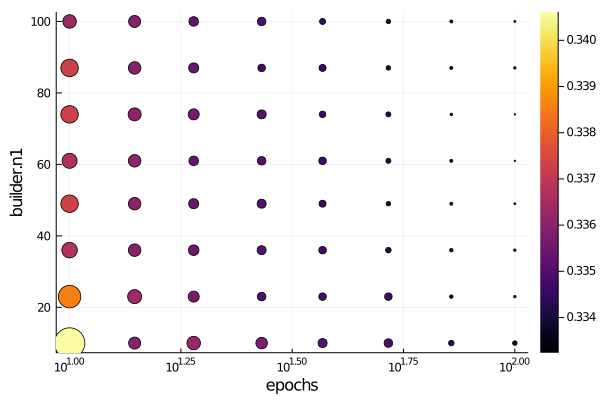

In [234]:
plot(self_tuning_nn)

In [235]:
best = fitted_params(self_tuning_nn)
best

(best_model = NeuralNetworkClassifier{CustomNN,…} @177,
 best_fitted_params = (chain = Chain(Chain(Dense(8, 61, σ), Dense(61, 40, σ), Dense(40, 2, σ)), softmax),),)

In [236]:
best.best_model

NeuralNetworkClassifier(
    builder = CustomNN(
            n1 = 61,
            n2 = 40),
    finaliser = NNlib.softmax,
    optimiser = ADAM(0.0003333333333333333, (0.9, 0.999), IdDict{Any,Any}()),
    loss = Flux.crossentropy,
    epochs = 100,
    batch_size = 16,
    lambda = 0.01,
    alpha = 0.0,
    optimiser_changes_trigger_retraining = false) @177

In [237]:
best_loss = z.report.best_result.measurement[1]

0.3332383f0

In [238]:
best_n1 = best.best_model.builder.n1

61

In [83]:
fn = "Figures/Grid_NN_$(param1):$(best.best_model.epochs)_x_$(param2):$(best_n1)_bestloss:$(best_loss)"
f = replace(fn,'.' => ',')
png(f)

### GridSearch for Hidden Layer Size 2

In [84]:
nn = NeuralNetworkClassifier(builder=CustomNN(best_n1,layer2))

NeuralNetworkClassifier(
    builder = CustomNN(
            n1 = 23,
            n2 = 40),
    finaliser = NNlib.softmax,
    optimiser = ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}()),
    loss = Flux.crossentropy,
    epochs = 10,
    batch_size = 1,
    lambda = 0.0,
    alpha = 0.0,
    optimiser_changes_trigger_retraining = false) @237

In [85]:
nn.optimiser.eta = 0.001
nn.epochs = 60
nn.batch_size = batch_sz
nn.lambda = 0.01

0.01

In [86]:
Net = machine(nn, X_stand, y)

Machine{NeuralNetworkClassifier{CustomNN,…}} @330 trained 0 times.
  args: 
    1:	Source @833 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @795 ⏎ `AbstractArray{Multiclass{2},1}`


In [94]:
param1 = :epochs
# param1 = :(builder.n1)
param2 = :(builder.n2)

r1 = range(nn, param1, lower=10, upper=100, scale=:log10)
# r1 = range(nn, param1, lower=1, upper=100, scale=:linear)
r2 = range(nn, param2, lower=5, upper=best_n1, scale=:linear)

MLJBase.NumericRange(Int64, :(builder.n2), ... )

In [95]:
self_tuning_nn_model = TunedModel(model=nn,
                                    tuning=Grid(goal=64),
                                    resampling=Holdout(fraction_train=0.7), 
                                    measure=cross_entropy,
                                    acceleration=CPUThreads(),
                                    range=[r1, r2])

ProbabilisticTunedModel(
    model = NeuralNetworkClassifier(
            builder = CustomNN @315,
            finaliser = NNlib.softmax,
            optimiser = ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}()),
            loss = Flux.crossentropy,
            epochs = 60,
            batch_size = 16,
            lambda = 0.01,
            alpha = 0.0,
            optimiser_changes_trigger_retraining = false),
    tuning = Grid(
            goal = 64,
            resolution = 10,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    resampling = Holdout(
            fraction_train = 0.7,
            shuffle = false,
            rng = Random._GLOBAL_RNG()),
    measure = cross_entropy(
            eps = 2.220446049250313e-16),
    weights = nothing,
    operation = MLJModelInterface.predict,
    range = MLJBase.NumericRange{Int64,MLJBase.Bounded,Symbol}[NumericRange{Int64,…} @045, NumericRange{Int64,…} @423],
    train_best = true,
    repeats = 1,
    n = nothing,
    a

In [96]:
self_tuning_nn = machine(self_tuning_nn_model, X_stand, y)

Machine{ProbabilisticTunedModel{Grid,…}} @517 trained 0 times.
  args: 
    1:	Source @821 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @081 ⏎ `AbstractArray{Multiclass{2},1}`


In [97]:
z = fit!(self_tuning_nn, rows=train)

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…}} @517.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
┌ Info: Attempting to evaluate 64 models.
└ @ MLJTuning /home/andrew/.julia/packages/MLJTuning/Bbgvk/src/tuned_models.jl:494
Evaluating over 64 metamodels: 100%[=========================] Time: 0:03:46


Machine{ProbabilisticTunedModel{Grid,…}} @517 trained 1 time.
  args: 
    1:	Source @821 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @081 ⏎ `AbstractArray{Multiclass{2},1}`


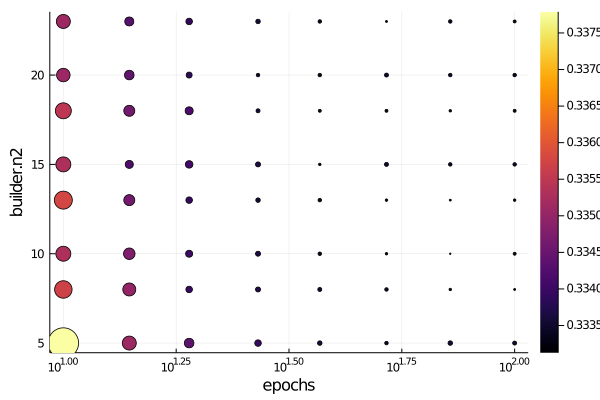

In [98]:
plot(self_tuning_nn)

In [99]:
best = fitted_params(self_tuning_nn)
best

(best_model = NeuralNetworkClassifier{CustomNN,…} @733,
 best_fitted_params = (chain = Chain(Chain(Dense(8, 23, σ), Dense(23, 10, σ), Dense(10, 2, σ)), softmax),),)

In [100]:
best.best_model

NeuralNetworkClassifier(
    builder = CustomNN(
            n1 = 23,
            n2 = 10),
    finaliser = NNlib.softmax,
    optimiser = ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}()),
    loss = Flux.crossentropy,
    epochs = 72,
    batch_size = 16,
    lambda = 0.01,
    alpha = 0.0,
    optimiser_changes_trigger_retraining = false) @733

In [101]:
best_loss = z.report.best_result.measurement[1]

0.33312795f0

In [102]:
best_n2 = best.best_model.builder.n2

10

In [103]:
fn = "Figures/Grid_NN_$(param1):$(best.best_model.epochs)_x_$(param2):$(best_n2)_bestloss:$(best_loss)"
png(replace(fn,'.' => ','))

### GridSearch for Learning Rate

In [119]:
nn = NeuralNetworkClassifier(builder=CustomNN(best_n1,best_n2))

NeuralNetworkClassifier(
    builder = CustomNN(
            n1 = 23,
            n2 = 10),
    finaliser = NNlib.softmax,
    optimiser = ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}()),
    loss = Flux.crossentropy,
    epochs = 10,
    batch_size = 1,
    lambda = 0.0,
    alpha = 0.0,
    optimiser_changes_trigger_retraining = false) @609

In [120]:
nn.optimiser.eta = 0.001
nn.epochs = 60
nn.batch_size = batch_sz
nn.lambda = 0.01

0.01

In [121]:
Net = machine(nn, X_stand, y)

Machine{NeuralNetworkClassifier{CustomNN,…}} @989 trained 0 times.
  args: 
    1:	Source @376 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @708 ⏎ `AbstractArray{Multiclass{2},1}`


In [122]:
fit!(Net, rows=train, verbosity=1, force=true)

┌ Info: Training Machine{NeuralNetworkClassifier{CustomNN,…}} @989.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
Optimising neural net:100%[=========================] Time: 0:00:07


Machine{NeuralNetworkClassifier{CustomNN,…}} @989 trained 1 time.
  args: 
    1:	Source @376 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @708 ⏎ `AbstractArray{Multiclass{2},1}`


In [129]:
param1 = :epochs
param2 = :(optimiser.eta)

r1 = range(nn, param1, lower=10, upper=100, scale=:linear)
r2 = range(nn, param2, lower=0.0001, upper=0.1, scale=:log10)

MLJBase.NumericRange(Float64, :(optimiser.eta), ... )

In [130]:
self_tuning_nn_model = TunedModel(model=nn,
                                    tuning=Grid(goal=49),
                                    resampling=Holdout(fraction_train=0.7), 
                                    measure=cross_entropy,
#                                     acceleration=CPUThreads(),
                                    range=[r1, r2])

ProbabilisticTunedModel(
    model = NeuralNetworkClassifier(
            builder = CustomNN @102,
            finaliser = NNlib.softmax,
            optimiser = ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}()),
            loss = Flux.crossentropy,
            epochs = 60,
            batch_size = 16,
            lambda = 0.01,
            alpha = 0.0,
            optimiser_changes_trigger_retraining = false),
    tuning = Grid(
            goal = 49,
            resolution = 10,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    resampling = Holdout(
            fraction_train = 0.7,
            shuffle = false,
            rng = Random._GLOBAL_RNG()),
    measure = cross_entropy(
            eps = 2.220446049250313e-16),
    weights = nothing,
    operation = MLJModelInterface.predict,
    range = MLJBase.NumericRange{T,MLJBase.Bounded,Symbol} where T[NumericRange{Int64,…} @660, NumericRange{Float64,…} @007],
    train_best = true,
    repeats = 1,
    n = nothing,

In [131]:
self_tuning_nn = machine(self_tuning_nn_model, X_stand, y)

Machine{ProbabilisticTunedModel{Grid,…}} @215 trained 0 times.
  args: 
    1:	Source @480 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @225 ⏎ `AbstractArray{Multiclass{2},1}`


In [132]:
z = fit!(self_tuning_nn, rows=train, force=true)

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…}} @215.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
┌ Info: Attempting to evaluate 49 models.
└ @ MLJTuning /home/andrew/.julia/packages/MLJTuning/Bbgvk/src/tuned_models.jl:494
Evaluating over 49 metamodels: 100%[=========================] Time: 0:02:19


Machine{ProbabilisticTunedModel{Grid,…}} @215 trained 1 time.
  args: 
    1:	Source @480 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @225 ⏎ `AbstractArray{Multiclass{2},1}`


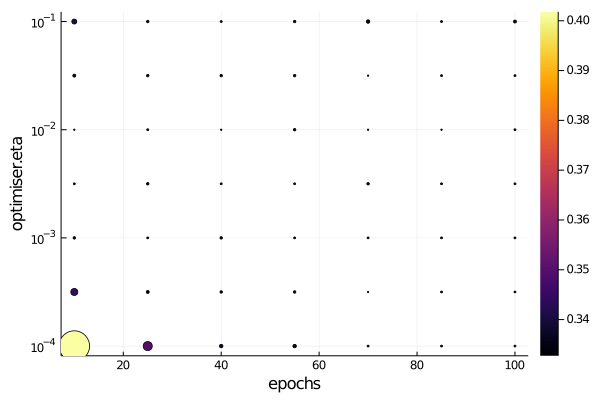

In [133]:
plot(self_tuning_nn)

In [134]:
best = fitted_params(self_tuning_nn)
best

(best_model = NeuralNetworkClassifier{CustomNN,…} @376,
 best_fitted_params = (chain = Chain(Chain(Dense(8, 23, σ), Dense(23, 10, σ), Dense(10, 2, σ)), softmax),),)

In [135]:
best.best_model

NeuralNetworkClassifier(
    builder = CustomNN(
            n1 = 23,
            n2 = 10),
    finaliser = NNlib.softmax,
    optimiser = ADAM(0.01, (0.9, 0.999), IdDict{Any,Any}()),
    loss = Flux.crossentropy,
    epochs = 10,
    batch_size = 16,
    lambda = 0.01,
    alpha = 0.0,
    optimiser_changes_trigger_retraining = false) @376

In [136]:
best_loss = z.report.best_result.measurement[1]

0.3327258f0

In [137]:
best_eta = round(best.best_model.optimiser.eta, digits=5)

0.01

In [138]:
fn = "Figures/Grid_NN_$(param1):$(best.best_model.epochs)_x_$(param2):$(best_eta)_bestloss:$(best_loss)_hidden:$b"
png(replace(fn,'.' => ','))

### GridSearch for Regularization

In [139]:
nn = NeuralNetworkClassifier(builder=CustomNN(best_n1,best_n2))

NeuralNetworkClassifier(
    builder = CustomNN(
            n1 = 23,
            n2 = 10),
    finaliser = NNlib.softmax,
    optimiser = ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}()),
    loss = Flux.crossentropy,
    epochs = 10,
    batch_size = 1,
    lambda = 0.0,
    alpha = 0.0,
    optimiser_changes_trigger_retraining = false) @755

In [140]:
nn.optimiser.eta = best_eta
nn.epochs = 60
nn.batch_size = batch_sz
nn.lambda = 0.01

0.01

In [141]:
Net = machine(nn, X_stand, y)

Machine{NeuralNetworkClassifier{CustomNN,…}} @808 trained 0 times.
  args: 
    1:	Source @852 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @599 ⏎ `AbstractArray{Multiclass{2},1}`


In [147]:
param1 = :epochs
param2 = :lambda

r1 = range(nn, param1, lower=10, upper=100, scale=:linear)
r2 = range(nn, param2, lower=0.0001, upper=10, scale=:log10)

MLJBase.NumericRange(Float64, :lambda, ... )

In [148]:
self_tuning_nn_model = TunedModel(model=nn,
                                    tuning=Grid(goal=50),
                                    resampling=Holdout(fraction_train=0.7), 
                                    measure=cross_entropy,
                                    acceleration=CPUThreads(),
                                    range=[r1, r2])

ProbabilisticTunedModel(
    model = NeuralNetworkClassifier(
            builder = CustomNN @196,
            finaliser = NNlib.softmax,
            optimiser = ADAM(0.01, (0.9, 0.999), IdDict{Any,Any}()),
            loss = Flux.crossentropy,
            epochs = 60,
            batch_size = 16,
            lambda = 0.01,
            alpha = 0.0,
            optimiser_changes_trigger_retraining = false),
    tuning = Grid(
            goal = 50,
            resolution = 10,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    resampling = Holdout(
            fraction_train = 0.7,
            shuffle = false,
            rng = Random._GLOBAL_RNG()),
    measure = cross_entropy(
            eps = 2.220446049250313e-16),
    weights = nothing,
    operation = MLJModelInterface.predict,
    range = MLJBase.NumericRange{T,MLJBase.Bounded,Symbol} where T[NumericRange{Int64,…} @660, NumericRange{Float64,…} @334],
    train_best = true,
    repeats = 1,
    n = nothing,


In [149]:
self_tuning_nn = machine(self_tuning_nn_model, X_stand, y)

Machine{ProbabilisticTunedModel{Grid,…}} @077 trained 0 times.
  args: 
    1:	Source @222 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @471 ⏎ `AbstractArray{Multiclass{2},1}`


In [150]:
z = fit!(self_tuning_nn, rows=train)

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…}} @077.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
┌ Info: Attempting to evaluate 49 models.
└ @ MLJTuning /home/andrew/.julia/packages/MLJTuning/Bbgvk/src/tuned_models.jl:494
Evaluating over 49 metamodels: 100%[=========================] Time: 0:03:41


Machine{ProbabilisticTunedModel{Grid,…}} @077 trained 1 time.
  args: 
    1:	Source @222 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @471 ⏎ `AbstractArray{Multiclass{2},1}`


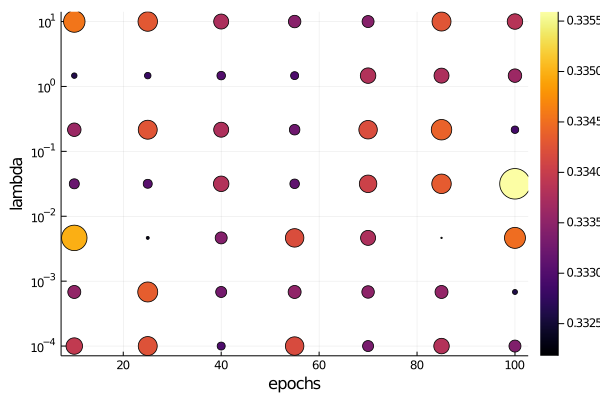

In [151]:
plot(self_tuning_nn)

In [152]:
best = fitted_params(self_tuning_nn)
best

(best_model = NeuralNetworkClassifier{CustomNN,…} @345,
 best_fitted_params = (chain = Chain(Chain(Dense(8, 23, σ), Dense(23, 10, σ), Dense(10, 2, σ)), softmax),),)

In [153]:
best.best_model

NeuralNetworkClassifier(
    builder = CustomNN(
            n1 = 23,
            n2 = 10),
    finaliser = NNlib.softmax,
    optimiser = ADAM(0.01, (0.9, 0.999), IdDict{Any,Any}()),
    loss = Flux.crossentropy,
    epochs = 85,
    batch_size = 16,
    lambda = 0.004641588833612777,
    alpha = 0.0,
    optimiser_changes_trigger_retraining = false) @345

In [154]:
best_loss = z.report.best_result.measurement[1]

0.33218125f0

In [155]:
best_lambda = best.best_model.lambda

0.004641588833612777

In [156]:
fn = "Figures/Grid_NN_$(param1):$(best.best_model.epochs)_x_$(param2):$(best_lambda)_bestloss:$(best_loss)"
png(replace(fn,'.' => ','))

### Learning Curve

In [195]:
lc_model = NeuralNetworkClassifier(builder=CustomNN(best_n1,best_n2))
lc_model.optimiser.eta = best_eta;
lc_model.lambda = best_lambda
lc_model.epochs = max_epochs
lc_model.batch_size = batch_sz
lc_model

NeuralNetworkClassifier(
    builder = CustomNN(
            n1 = 23,
            n2 = 10),
    finaliser = NNlib.softmax,
    optimiser = ADAM(0.01, (0.9, 0.999), IdDict{Any,Any}()),
    loss = Flux.crossentropy,
    epochs = 2000,
    batch_size = 16,
    lambda = 0.004641588833612777,
    alpha = 0.0,
    optimiser_changes_trigger_retraining = false) @447

In [163]:
# lc_model = NeuralNetworkClassifier(builder=CustomNN(80,80))
# lc_model.optimiser.eta = 0.001;
# lc_model.lambda = best_lambda
# lc_model.epochs = 3000
# lc_model.batch_size = 8

In [164]:
mce(x,y) = mean(cross_entropy(x,y))

mce (generic function with 1 method)

In [168]:
data_schedule, training_losses, valid_losses = learn_curve(lc_model, X[train,:], y[train], mce, step=200)

(d, train_metric, valid_metric) = (10, 0.31399745f0, 0.39655364f0)
(d, train_metric, valid_metric) = (210, 0.32756144f0, 0.3468956f0)
(d, train_metric, valid_metric) = (410, 0.347708f0, 0.35172537f0)
(d, train_metric, valid_metric) = (610, 0.3378521f0, 0.34273827f0)
(d, train_metric, valid_metric) = (810, 0.3502987f0, 0.35292587f0)
(d, train_metric, valid_metric) = (1010, 0.345935f0, 0.33880046f0)
(d, train_metric, valid_metric) = (1210, 0.3414976f0, 0.34097737f0)
(d, train_metric, valid_metric) = (1410, 0.35368723f0, 0.34997356f0)
(d, train_metric, valid_metric) = (1610, 0.34493867f0, 0.34478602f0)
(d, train_metric, valid_metric) = (1810, 0.339781f0, 0.3419927f0)
(d, train_metric, valid_metric) = (2010, 0.3426148f0, 0.344235f0)
(d, train_metric, valid_metric) = (2210, 0.3390535f0, 0.3388004f0)
(d, train_metric, valid_metric) = (2410, 0.33823505f0, 0.33856162f0)
(d, train_metric, valid_metric) = (2610, 0.34314668f0, 0.34318984f0)
(d, train_metric, valid_metric) = (2810, 0.33884242f0, 0

(10:200:10010, Any[0.31399745f0, 0.32756144f0, 0.347708f0, 0.3378521f0, 0.3502987f0, 0.345935f0, 0.3414976f0, 0.35368723f0, 0.34493867f0, 0.339781f0  …  0.3393275f0, 0.34204096f0, 0.33927795f0, 0.3389352f0, 0.33901086f0, 0.33926666f0, 0.35289988f0, 0.33886003f0, 0.3384053f0, 0.3397352f0], Any[0.39655364f0, 0.3468956f0, 0.35172537f0, 0.34273827f0, 0.35292587f0, 0.33880046f0, 0.34097737f0, 0.34997356f0, 0.34478602f0, 0.3419927f0  …  0.33840135f0, 0.34372762f0, 0.33976185f0, 0.33817306f0, 0.33760557f0, 0.33970758f0, 0.35332575f0, 0.33919936f0, 0.33885935f0, 0.3419927f0])

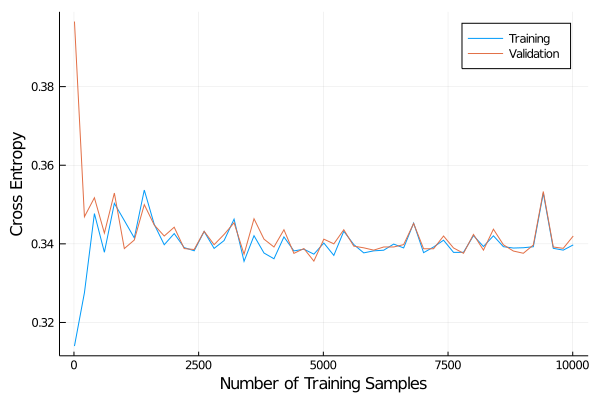

In [169]:
plot(data_schedule, training_losses, label="Training")
plot!(data_schedule, valid_losses, label="Validation")
xlabel!("Number of Training Samples")
ylabel!("Cross Entropy")

In [170]:
png("Figures/loss_curve_NN")

#### Learning Curve

In [196]:
Net = machine(lc_model, X_stand, y)
Net.model.epochs = max_epochs
fit!(Net, rows=train, verbosity=1, force=true)

┌ Info: Training Machine{NeuralNetworkClassifier{CustomNN,…}} @348.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
Optimising neural net:100%[=========================] Time: 0:04:22


Machine{NeuralNetworkClassifier{CustomNN,…}} @348 trained 1 time.
  args: 
    1:	Source @411 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @126 ⏎ `AbstractArray{Multiclass{2},1}`


In [197]:
nn_acc = evaluate!(Net, resampling=CV(shuffle=true), measure=[cross_entropy, acc], verbosity=1)

Evaluating over 6 folds: 100%[=========================] Time: 0:30:47


┌───────────────┬───────────────┬──────────────────────────────────────────────────┐
│ _.measure     │ _.measurement │ _.per_fold                                       │
├───────────────┼───────────────┼──────────────────────────────────────────────────┤
│ cross_entropy │ 0.334         │ Float32[0.33, 0.335, 0.335, 0.335, 0.336, 0.334] │
│ acc           │ 0.979         │ [0.983, 0.979, 0.978, 0.979, 0.977, 0.98]        │
└───────────────┴───────────────┴──────────────────────────────────────────────────┘
_.per_observation = [[[0.313, 0.313, ..., 0.313], [0.313, 0.313, ..., 0.313], [1.31, 0.313, ..., 0.313], [0.313, 0.313, ..., 0.313], [0.313, 0.313, ..., 0.313], [0.313, 0.313, ..., 0.313]], missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


In [198]:
r = range(nn, :epochs, lower=1, upper=max_epochs, scale=:log10)

MLJBase.NumericRange(Int64, :epochs, ... )

In [199]:
curve = MLJ.learning_curve(Net, 
                        range=r, 
                        resampling=Holdout(fraction_train=0.7), 
#                         resampling=CV(nfolds=4), 
                        measure=cross_entropy, 
                        acceleration=CPUProcesses(),
                        resolution=200
)

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…}} @948.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
┌ Info: Attempting to evaluate 140 models.
└ @ MLJTuning /home/andrew/.julia/packages/MLJTuning/Bbgvk/src/tuned_models.jl:494
Evaluating over 140 metamodels: 100%[=========================] Time: 0:04:20


(parameter_name = "epochs",
 parameter_scale = :log10,
 parameter_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  1418, 1473, 1531, 1590, 1652, 1717, 1783, 1853, 1925, 2000],
 measurements = [0.32340991497039795, 0.32421961426734924, 0.3246641755104065, 0.3255248963832855, 0.3258017599582672, 0.3257544934749603, 0.32438090443611145, 0.3260870575904846, 0.3259798586368561, 0.3255012035369873  …  0.32697558403015137, 0.3257824778556824, 0.3272705376148224, 0.32662734389305115, 0.32628968358039856, 0.3264675438404083, 0.32637637853622437, 0.3269162178039551, 0.32682329416275024, 0.32630789279937744],)

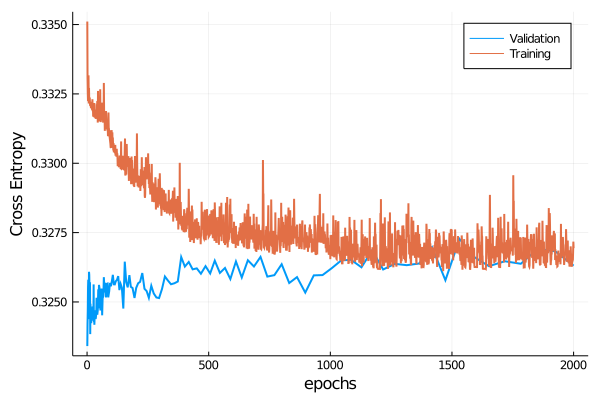

In [200]:
plot(curve.parameter_values,
     curve.measurements,
     xlab=curve.parameter_name,
     ylab="Cross Entropy",
     label="Validation", lw=2)
plot!(Net.report.training_losses, label="Training", lw=2)

In [201]:
best_epochs = curve.parameter_values[argmin(curve.measurements)]

1

In [ ]:
png("Figures/learning_curve_nn_$(best_epochs)epochs_balance")

# Final Results

In [177]:
final_model = NeuralNetworkClassifier(builder=CustomNN(best_n1,best_n2))

NeuralNetworkClassifier(
    builder = CustomNN(
            n1 = 23,
            n2 = 10),
    finaliser = NNlib.softmax,
    optimiser = ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}()),
    loss = Flux.crossentropy,
    epochs = 10,
    batch_size = 1,
    lambda = 0.0,
    alpha = 0.0,
    optimiser_changes_trigger_retraining = false) @022

In [178]:
final_model.optimiser.eta = lc_model.optimiser.eta = best_eta;
final_model.batch_size = batch_sz
final_model.lambda = best_lambda
final_model.epochs = best_epochs

22

### Test Performance

In [179]:
Final_Net = machine(final_model, X_stand, y)

Machine{NeuralNetworkClassifier{CustomNN,…}} @896 trained 0 times.
  args: 
    1:	Source @904 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @408 ⏎ `AbstractArray{Multiclass{2},1}`


In [180]:
fit!(Final_Net, rows=train, force=true, verbosity=1)

┌ Info: Training Machine{NeuralNetworkClassifier{CustomNN,…}} @896.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
Optimising neural net:100%[=========================] Time: 0:00:02


Machine{NeuralNetworkClassifier{CustomNN,…}} @896 trained 1 time.
  args: 
    1:	Source @904 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @408 ⏎ `AbstractArray{Multiclass{2},1}`


In [181]:
nn_acc = evaluate!(Final_Net, resampling=CV(shuffle=true), measure=[cross_entropy, acc], verbosity=1)

Evaluating over 6 folds: 100%[=========================] Time: 0:00:18


┌───────────────┬───────────────┬──────────────────────────────────────────────────┐
│ _.measure     │ _.measurement │ _.per_fold                                       │
├───────────────┼───────────────┼──────────────────────────────────────────────────┤
│ cross_entropy │ 0.333         │ Float32[0.336, 0.331, 0.33, 0.329, 0.336, 0.336] │
│ acc           │ 0.979         │ [0.976, 0.982, 0.983, 0.983, 0.977, 0.975]       │
└───────────────┴───────────────┴──────────────────────────────────────────────────┘
_.per_observation = [[[0.313, 0.313, ..., 0.313], [0.313, 0.313, ..., 0.313], [0.313, 0.313, ..., 0.313], [0.313, 0.313, ..., 0.313], [0.313, 0.313, ..., 0.313], [0.313, 0.313, ..., 0.313]], missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


In [182]:
ŷ = MLJ.predict(Final_Net, X_stand[test,:]);

In [183]:
cross_entropy(ŷ, y[test]) |> mean

0.33408886f0

In [184]:
acc(ŷ, y[test])

0.9789571694599628

In [185]:
confusion_matrix(mode.(ŷ), y[test])

┌ Warning: The classes are un-ordered,
│ using: negative='0' and positive='1'.
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/measures/confusion_matrix.jl:83


              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │      0      │      1      │
├─────────────┼─────────────┼─────────────┤
│      0      │    4850     │     85      │
├─────────────┼─────────────┼─────────────┤
│      1      │     28      │     407     │
└─────────────┴─────────────┴─────────────┘


In [186]:
fitted_params(Final_Net)

(chain = Chain(Chain(Dense(8, 23, σ), Dense(23, 10, σ), Dense(10, 2, σ)), softmax),)

In [187]:
report(Final_Net)

(training_losses = Any[0.33678392f0, 0.3348841f0, 0.3328578f0, 0.33268696f0, 0.33278093f0, 0.33231866f0, 0.33366203f0, 0.33206198f0, 0.33202043f0, 0.3323865f0  …  0.3316797f0, 0.33173674f0, 0.33190975f0, 0.33163416f0, 0.33195397f0, 0.33153185f0, 0.3314146f0, 0.33130473f0, 0.33140054f0, 0.33165658f0],)